# Natural Language Processing:<br>LDA Topic Modeling
- __Date__: June 26, 2020
- __Author__: Yeji Soh
- __Description__: <br>
    - (1) Web scraping either the posts since time t or last x number of posts.
    - (2) LDA Topic modeling on scraped articles.

### Import necessary libraries

In [1]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
from dateutil.parser import parse
import math
import csv
import re
import string
import sklearn
import gensim
import numpy as np
import pandas as pd
import tqdm

In [2]:
import spacy
#spacy.load("en_core_web_sm")
#from nltk.stem import PorterStemmer
#from nltk.wordnet import WordNetLemmatizer()
#from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize.toktok import ToktokTokenizer
import contractions
import unicodedata

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!python3 -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 50 kB/s eta 0:00:011
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.0-py3-none-any.whl size=12048606 sha256=3a4ac990bddaa9d8fdbc195b8561f6e1bba3de39d665055dc555a75f8b36aabe
  Stored in directory: /tmp/pip-ephem-wheel-cache-6sp22ua1/wheels/71/4a/56/e48f8ad9359a6780edd8cdd42955519b1a21d6365ad15628a2
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
import en_core_web_sm

## 01. Web Scraping

### Calculate The Last Page Number
To be able to set the last iteration number, we should calculate the last page number of the webpage that we'd like to scrape.

In [3]:
lastPage = 1
response = get('https://www.worldvision.ca/stories?Page={}'.format(lastPage))
response2 = get('https://www.worldvision.ca/stories?Page={}'.format(lastPage+1))
htmlSoup = BeautifulSoup(response.text, 'html.parser')
htmlSoup2 = BeautifulSoup(response2.text, 'html.parser')

while htmlSoup.find('div', class_="center-v").find('span','news-title').text != htmlSoup2.find('div', class_="center-v").find('span','news-title').text:
    lastPage += 1
    response = get('https://www.worldvision.ca/stories?Page={}'.format(lastPage))
    response2 = get('https://www.worldvision.ca/stories?Page={}'.format(lastPage+1))
    htmlSoup = BeautifulSoup(response.text, 'html.parser')
    htmlSoup2 = BeautifulSoup(response2.text, 'html.parser')
    print(lastPage)

2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [4]:
lastPage

15

### Function: getPosts(since, number)
- Note that each page has 20 articles for this particular webpage.
- Input:
    - __since__ or __number__: Users should choose either they would like to see the posts since any certain time, or to see certain number of posts. For the first case, replace 'since' with any certain time, with typing "" for number parameter. For the second case, replace 'number' with any number, with typing "" for since parameter.<br>Ex) getPosts("2020-01-01",""), or getPosts("", 60)
- Output:
    - It'll generate a csv file called 'WorldVision.csv', having requested posts information in it.
    - It'll return a data frame, having requested posts information in it.

In [5]:
def getPosts(since, number):
    
    # Make an empty list to contain all the news div tags of all pages
    newsContainersList=[]
    
    # When the number of posts is given as an input,
    # as we know each page has 20 articles,
    # it's possible to know which page is the last page that we should finish scraping.
    if since == "":
        pages = math.ceil(number/20)
    # When since is given as an input,
    # we're not sure which page is the last page that finishes up scraping,
    # so set the very lastPage as the last iteration point in the beginning,
    # but exit the loop when 'since' date is greater than any post's date.(specified later)
    if number == "":
        pages = lastPage
    
    for page in range(1, pages+1):
        response = get('https://www.worldvision.ca/stories?Page={}'.format(page))
        htmlSoup = BeautifulSoup(response.text, 'html.parser')
        # Find container that contains all the news in each page
        newsContainers = htmlSoup.find_all('div', class_='news-row clearfix')
        # Now newsContainersList will have all the news div-tags of each page
        newsContainersList.append(newsContainers)
    
    # Make empty lists to contain each page's articles info.
    TitleList = []
    SubtitleList = []
    UrlList = []
    DateList = []
    ContentList = []
    count = 1

    defaultURL = 'https://www.worldvision.ca'
    
    with open('WorldVision.csv', mode='w', encoding='utf-8') as csv_file:
        fieldnames = ['Date','Title','Subtitles','Content','Link']
        writer = csv.DictWriter(csv_file, fieldnames = fieldnames)
        writer.writeheader()
        
        # Extract each news' info (url, date, title, subtitle, content)
        # newsContainers: all the news in each page
        # newsContainersList: all the news in all pages
        for newsContainers in newsContainersList:
            # Make empty lists to contain necessary info
            Title = []
            Subtitle = []
            Url = []
            Date = []
            Content = []
            
            # nc: each news
            # newsContainers: all the news in each page
            for nc in newsContainers:
                url = defaultURL + nc.find('a')['href']
                responseText = get(url).text
                htmlSoup = BeautifulSoup(responseText, 'html.parser')
                mainContents = htmlSoup.find_all('div', class_='main-content')
                date = mainContents[0].span.text.strip()
                
                # Exit the loop when 'since' date is greater than any post's date
                if number == "":
                    if parse(date) < parse(since):
                        return
                
                # Get title
                title = mainContents[0].find('div', class_="news-title").find('h1').text.strip()
                
                # Get subtitles
                No_h2 = len(mainContents[0].find('div', class_='col-md-8 col-md-offset-2 news-story margin-bottom-lg').find_all('h2'))
                All_h2 = ""
                for j in range(No_h2):
                    All_h2 += mainContents[0].find('div', class_='col-md-8 col-md-offset-2 news-story margin-bottom-lg').find_all('h2')[j].text + ','
                    if j == No_h2 - 1:
                        All_h2 += mainContents[0].find('div', class_='col-md-8 col-md-offset-2 news-story margin-bottom-lg').find_all('h2')[j].text
                
                subtitles = All_h2
                
                # Get content
                content = mainContents[0].find('div', class_="col-md-8 col-md-offset-2 news-story margin-bottom-lg").text.strip()
                
                # Title, Subtitles, Url, Date, Content are the lists of each article info
                Title.append(title)
                Subtitle.append(subtitles)
                Url.append(url)
                Date.append(date)
                Content.append(content)
                
                # Now that date, title, subtitles, content, url info is set,
                # Assign to each row
                writer.writerow({'Date':date,'Title':title,'Subtitles':subtitles,'Content':content,'Link':url})
                # print Success every time new row is added
                print('Success: Article {}!'.format(count))
                
                count += 1
                
                # Exit the loop when the number of posts scraped becomes greater than user's input number
                if since == "":
                    if count > number:
                        return
            
            # TitleList, SubtitleList, UrlList, DateList, ContentList are the lists of each page info
            TitleList.append(Title)
            SubtitleList.append(Subtitle)
            UrlList.append(Url)
            DateList.append(Date)
            ContentList.append(Content)
    
    # Store list data to data frame
    #data = {'Date': sum(DateList, []), 'Title': sum(TitleList, []), 'Subtitles': sum(SubtitleList, []), 'Content': sum(ContentList, []), 'Link': sum(UrlList, [])}
    #df = pd.DataFrame(data=data)
    #return df

In [6]:
getPosts("", 60)

Success: Article 1!
Success: Article 2!
Success: Article 3!
Success: Article 4!
Success: Article 5!
Success: Article 6!
Success: Article 7!
Success: Article 8!
Success: Article 9!
Success: Article 10!
Success: Article 11!
Success: Article 12!
Success: Article 13!
Success: Article 14!
Success: Article 15!
Success: Article 16!
Success: Article 17!
Success: Article 18!
Success: Article 19!
Success: Article 20!
Success: Article 21!
Success: Article 22!
Success: Article 23!
Success: Article 24!
Success: Article 25!
Success: Article 26!
Success: Article 27!
Success: Article 28!
Success: Article 29!
Success: Article 30!
Success: Article 31!
Success: Article 32!
Success: Article 33!
Success: Article 34!
Success: Article 35!
Success: Article 36!
Success: Article 37!
Success: Article 38!
Success: Article 39!
Success: Article 40!
Success: Article 41!
Success: Article 42!
Success: Article 43!
Success: Article 44!
Success: Article 45!
Success: Article 46!
Success: Article 47!
Success: Article 48!
S

## 02. Data Cleaning

__2.1. Import Dataset__

In [5]:
df = pd.read_csv('WorldVision.csv')

In [6]:
df.shape

(60, 5)

In [7]:
# Convert data frame's content into a list format, and
# assign it into texts variable
texts = df['Content'].tolist()

In [140]:
len(df['Content'].values.tolist())

60

__2.2. Lower casing and remove special characters__

In [8]:
def clean_text_round1(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub('[‘’“”…]',' ',text)
    text = re.sub('\n',' ',text)
    text = re.sub('\r',' ',text)
    text = re.sub("’",'',text)
    text = re.sub("–",'',text)
    text = re.sub("—",'',text)
    text = re.sub(u'\xa0', u' ',text)
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text
round1 = lambda x: clean_text_round1(x)

In [131]:
round1_text=[]
for text in texts:
    round1_text.append(clean_text_round1(text))
#round1_text

__2.3. Named Entity Recognition(NER) & Recognize ngrams__<br><br>
According to <a href='https://en.wikipedia.org/wiki/Named-entity_recognition'>Wikipedia</a>, _Named-entity recognition_ is a subtask of information extraction that seeks to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.<br>
The reason why ngraming with NER, rather than Parser methods in gensim mdule, is because ngraming with named-entities does a better job than what gensim-parser does for ngraming. For example, for the word: 'eastern democratic republic of congo', if using gensim module's parser, it will return 4 separate words, such as 'eastern', 'democratic_republic', 'of','congo', while it makes more sense to recognize that as a one single word by manipulating named entity with connecting word-to-word with '_','eastern_democratic_republic_of_congo', so that it is considered as one single word when tokenizing.

In [10]:
# Create NER Dictionary, where key is the page index and values are the collection of named-entities for each article.
nlp = en_core_web_sm.load()

nerDict = {}
for i in range(len(round1_text)):
    t = "".join([w for w in round1_text[i]])
    a = nlp(t)
    entList = []
    for ent in a.ents:
        entList.append([ent.text, ent.label_])
    
    data = {i: entList}
    nerDict.update(data)
        
nerDict

{0: [['mugunga', 'GPE'],
  ['several miles', 'QUANTITY'],
  ['eastern democratic republic of congo', 'GPE'],
  ['the war i', 'EVENT'],
  ['six', 'CARDINAL'],
  ['six years old', 'DATE'],
  ['two months ago', 'DATE'],
  ['the democratic republic of congo', 'GPE'],
  ['kayla', 'GPE'],
  ['the past year', 'DATE'],
  ['early in the morning', 'TIME'],
  ['congolese francs', 'MONEY'],
  ['mugunga', 'GPE'],
  ['the world food programme world vision', 'ORG'],
  ['kayla', 'GPE']],
 1: [['weekly', 'DATE'],
  ['canada', 'GPE'],
  ['april', 'DATE'],
  ['last year', 'DATE'],
  ['canadians', 'NORP'],
  ['canadians', 'NORP'],
  ['canada', 'GPE'],
  ['million', 'CARDINAL'],
  ['the ivory coast', 'GPE'],
  ['guatemala', 'GPE'],
  ['thailand', 'GPE'],
  ['canada', 'GPE'],
  ['each year', 'DATE'],
  ['mithapukur', 'ORG'],
  ['batel', 'ORG'],
  ['sarker     ', 'PERSON'],
  ['ilo', 'ORG'],
  ['million', 'CARDINAL'],
  ['million', 'CARDINAL'],
  ['this year', 'DATE'],
  ['millions', 'CARDINAL'],
  ['the ivo

In [103]:
round2_text = []
for i in range(len(nerDict)):
    t = "".join([w for w in round1_text[i]])
    for j in range(len(nerDict[i])):
        # If any entity is PERSON, change the name to string 'PERSON_A'.
        if (nerDict[i][j][1] == 'PERSON') and (nerDict[i][j][0] in t):
            t = t.replace(nerDict[i][j][0], nerDict[i][j][1] + "_A ")
        # Ngraming:
        # Any other entities, change those chunks of words into one single word by connecting with "_"
        t = t.replace(nerDict[i][j][0], nerDict[i][j][0].replace(" ","_"))
    round2_text.append(t)

__2.5. Remove stopwords and Tokenize__

In [81]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['thi', 'wa','ve','ha','hi','lyn','carolyn', 'monica','nesadin','I','i','amina','shahid','raja','thing','will','would','because'])

In [132]:
from nltk.tokenize import word_tokenize
round3_text=[]
for text in round2_text:
    round3_text.append(word_tokenize(text))
#round3_text

In [133]:
# Store only non-stopwords into a list
Entire=[]
for tokens in round3_text:
    article=[]
    for token in tokens:
        if token not in stop_words:
            article.append(token)
    Entire.append(article)
#Entire

__2.4. Stemming__

In [134]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
E=[]
for i in range(len(Entire)):
    articleTokens=[]
    for j in range(len(Entire[i])):
        articleTokens.append(ps.stem(Entire[i][j]))
    E.append(articleTokens)
#E

In [136]:
# Remove possible remaining stop words again
EntireTokens=[]
for articleWords in E:
    a = []
    for word in articleWords:
        if word not in stop_words:
            a.append(word)
    EntireTokens.append(a)
EntireTokens[0]

['muombi',
 'live',
 'friend',
 'mugunga',
 'camp',
 'intern',
 'displac',
 'person',
 'idp',
 'several_mil',
 'outsid',
 'goma',
 'eastern_democratic_republic_of_congo',
 'separ',
 'mother',
 'famili',
 'fled',
 'fight',
 'villag',
 'mother',
 'ran',
 'away',
 'say',
 'muombi',
 'know',
 'went',
 'last',
 'time',
 'saw',
 'the_war_i',
 'take',
 'care',
 'hous',
 'went',
 'forest',
 'collect',
 'the_war_immedi',
 'start',
 'never',
 'saw',
 'alon',
 'live',
 'older',
 'brother',
 'six',
 'children',
 'homeless',
 'ongo',
 'conflict',
 'coupl',
 'global',
 'pandem',
 'meant',
 'school',
 'close',
 'muombi',
 'say',
 'school',
 'sinc',
 'six_years_old',
 'anyway',
 'sinc',
 'father',
 'die',
 'feel',
 'vulner',
 'muombi',
 'decid',
 'come',
 'idp',
 'camp',
 'search',
 'new',
 'life',
 'two_months_ago',
 'muombi',
 'say',
 'today',
 'live',
 'friend',
 'villag',
 'refuge',
 'muombi',
 'shelter',
 'friend',
 'crowd',
 'refuge',
 'camp',
 'the_democratic_republic_of_congo',
 'photo',
 'kay

__2.6. Consider Bigrams__

In [316]:
# bigram = gensim.models.Phrases(EntireTokens, min_count=5, threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)

In [317]:
# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

In [319]:
# Tokens_bg = make_bigrams(EntireTokens)
# Tokens_bg

## 03. LDA Topic Modeling

__Data Transformation: Corpus and Dictionary__

In [18]:
import gensim.corpora as corpora

In [86]:
# Create Dictionary
id2word = corpora.Dictionary(EntireTokens) 
#id2word_2 = corpora.Dictionary(Tokens_bg)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in EntireTokens]
#corpus_2 = [id2word_2.doc2bow(text) for text in Tokens_bg]

__Build the base topic model__

In [87]:
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, chunksize=100, passes=100, per_word_topics=True)

In [88]:
from pprint import pprint

# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"world" + 0.014*"children" + 0.011*"person_a" + 0.011*"vision" + '
  '0.010*"peopl" + 0.009*"water" + 0.008*"like" + 0.008*"help" + '
  '0.008*"countri" + 0.008*"famili"'),
 (1,
  '0.023*"person_a" + 0.013*"world" + 0.010*"volunt" + 0.010*"children" + '
  '0.008*"like" + 0.007*"child" + 0.007*"help" + 0.006*"fair_trad" + '
  '0.006*"work" + 0.005*"vision"'),
 (2,
  '0.023*"goat" + 0.016*"famili" + 0.013*"children" + 0.009*"person_a" + '
  '0.008*"help" + 0.007*"women" + 0.006*"say" + 0.005*"live" + 0.005*"world" + '
  '0.005*"photo"'),
 (3,
  '0.016*"person_a" + 0.014*"girl" + 0.014*"women" + 0.011*"world" + '
  '0.008*"iron" + 0.007*"children" + 0.007*"peopl" + 0.006*"countri" + '
  '0.006*"work" + 0.006*"drc"'),
 (4,
  '0.022*"food" + 0.020*"ebola" + 0.011*"health" + 0.009*"world" + '
  '0.009*"poverti" + 0.009*"peopl" + 0.009*"outbreak" + 0.008*"children" + '
  '0.008*"person_a" + 0.007*"secur"')]


__Compute Coherence Score__

In [89]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=EntireTokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.28325621805374274


__Assign a dominant topic to each article__

In [90]:
def AssignTopics(lda=None, corpus=corpus):
    # Init output
    result = pd.DataFrame()
    
    # Get main topic in each article
    for i, row_list in enumerate(lda[corpus]):
        # if lda.per_word_topics was set to be True, it means that
        # it's already in descending order, where the highest comes the first(0)
        row = row_list[0] if lda.per_word_topics else row_list
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get a dominant topic, % Contribution and keywords for each article
        for j, (topic_num, prob_topic) in enumerate(row):
            if j==0: # dominant topic
                wp = lda.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prob in wp])
                result = result.append(pd.Series([int(topic_num), round(prob_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    result.columns = ['Topic No.', '% Contribution', 'Topic keywords']
    
    # Add title to the end of dataframe
    title = pd.Series(df['Title'])
    result = pd.concat([result, title], axis=1)
    return(result)

In [130]:
AssignTopics(lda=lda_model, corpus=corpus).head()

,Topic No.,% Contribution,Topic keywords,Title
0,3.0,0.5362,"person_a, girl, women, world, iron, children, ...",“The hardness of life” for an unaccompanied ch...
1,1.0,0.9612,"person_a, world, volunt, children, like, child...",The rising risk of child labour due to COVID-19
2,0.0,0.5250,"world, children, person_a, vision, peopl, wate...",#HiddenHero: Delivering food assistance in Sou...
3,1.0,0.9984,"person_a, world, volunt, children, like, child...",What young Canadians are saying about COVID-19
4,4.0,0.9996,"food, ebola, health, world, poverti, peopl, ou...",The basics of food security (and how it’s tied...


## 04. Hyperparameter Tuning
To build a proper LDA topic model, it is important to select optimal parameters. This section is about selecting optimal parameters, such as alpha, beta, and the number of topics, by calculating coherence values.

In [92]:
def getCoherence(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=k, random_state=100, chunksize=100, passes=100, alpha=a, eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=EntireTokens, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [93]:
grid = {}
grid['Validation-Set'] = {}

# Topic range
min_topics = 2
max_topics = 12
step = 1
topics_range = range(min_topics, max_topics, step)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
numDocs = len(corpus)
corpusSets = [#gensim.utils.ClippedCorpus(corpus, numDocs * 0.5),
             corpus]
corpusTitle = ['100% Corpus']
modelResults = {'Validation-Set': [], 'Topics': [], 
                'Alpha': [], 'Beta': [], 'Coherence': []}

# Run - Find optimal parameters
if 1 == 1:
    pbar = tqdm.tqdm(total=len(beta)*len(alpha)*len(topics_range)*len(corpusTitle))
    
    # iterate through validation corpuses
    for i in range(len(corpusSets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterate through beta values
                for b in beta:
                    cv = getCoherence(corpus=corpusSets[i], dictionary=id2word, k=k, a=a, b=b)
                    
                    # Save each value
                    modelResults['Validation-Set'].append(corpusTitle[i])
                    modelResults['Topics'].append(k)
                    modelResults['Alpha'].append(a)
                    modelResults['Beta'].append(b)
                    modelResults['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(modelResults).to_csv('LDA_Tuning_Results.csv', index=False)
    pbar.close()

100%|██████████| 300/300 [2:12:32<00:00, 26.51s/it]  


In [123]:
df_cv = pd.read_csv('LDA_Tuning_Results.csv')
df_cv.head()

,Validation-Set,Topics,Alpha,Beta,Coherence
0,100% Corpus,2,0.01,0.01,0.273628
1,100% Corpus,2,0.01,0.31,0.273628
2,100% Corpus,2,0.01,0.61,0.273628
3,100% Corpus,2,0.01,0.9099999999999999,0.273628
4,100% Corpus,2,0.01,symmetric,0.273628


__Visualization__

In [111]:
import matplotlib
import matplotlib.pyplot as plt

In [124]:
# Select alpha=0.01, beta=0.91
filter_1 = df_cv[df_cv['Alpha']=='0.01']
filter_2 = filter_1[filter_1['Beta']=='0.9099999999999999']

In [97]:
filter_2

,Validation-Set,Topics,Alpha,Beta,Coherence
3,100% Corpus,2,0.01,0.9099999999999999,0.273628
33,100% Corpus,3,0.01,0.9099999999999999,0.310312
63,100% Corpus,4,0.01,0.9099999999999999,0.353797
93,100% Corpus,5,0.01,0.9099999999999999,0.423796
123,100% Corpus,6,0.01,0.9099999999999999,0.418520
153,100% Corpus,7,0.01,0.9099999999999999,0.484689
183,100% Corpus,8,0.01,0.9099999999999999,0.526053
213,100% Corpus,9,0.01,0.9099999999999999,0.406059
243,100% Corpus,10,0.01,0.9099999999999999,0.470130
273,100% Corpus,11,0.01,0.9099999999999999,0.425959


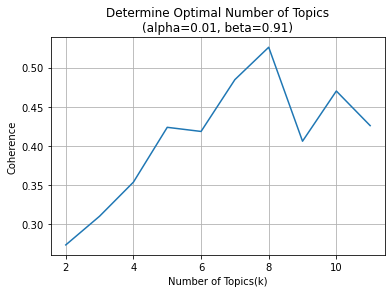

In [125]:
k = filter_2['Topics'].to_list()
cv = filter_2['Coherence'].to_list()

fig, ax = plt.subplots()
ax.plot(k, cv)

ax.set(xlabel='Number of Topics(k)', ylabel='Coherence', title='Determine Optimal Number of Topics\n(alpha=0.01, beta=0.91)')
ax.grid()
fig.savefig('Optimal_Number_of_Topics.png')
plt.show()

- __Observation__:<br>
In general, coherence is increasing with the number of topics. As topic coherence is the measurement of the degree of semantic similarity between high scoring words in the topic(<a href="https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0">reference</a>), it is better to pick the number of topics with higher coherence value. 4 or 5 seems to be proper to be picked as the number of topics, as 4 is an elbow point and 5 is where the drop begins.

## 05. Final Model & Visualization
After trying both 4 and 5 number of topics, it was observed that 4 topics makes more sense, as in case of 5, one topic was almost merged into the other.

In [120]:
FinalModel = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=4, random_state=100, chunksize=100, passes=100, alpha=0.01, eta=0.9099999999999999, per_word_topics=True)
pprint(FinalModel.print_topics())

[(0,
  '0.014*"world" + 0.011*"children" + 0.010*"person_a" + 0.008*"vision" + '
  '0.007*"peopl" + 0.007*"like" + 0.007*"famili" + 0.006*"help" + '
  '0.006*"countri" + 0.006*"live"'),
 (1,
  '0.019*"person_a" + 0.011*"world" + 0.007*"children" + 0.007*"volunt" + '
  '0.006*"child" + 0.006*"girl" + 0.006*"women" + 0.005*"like" + 0.005*"work" '
  '+ 0.005*"help"'),
 (2,
  '0.013*"ebola" + 0.010*"food" + 0.008*"goat" + 0.007*"children" + '
  '0.007*"famili" + 0.006*"peopl" + 0.006*"person_a" + 0.006*"women" + '
  '0.005*"drc" + 0.005*"health"'),
 (3,
  '0.013*"iron" + 0.008*"fish" + 0.007*"lucki" + 0.003*"defici" + '
  '0.002*"enterpris" + 0.001*"start" + 0.001*"tanzania" + 0.001*"research" + '
  '0.001*"shinyanga" + 0.001*"issu"')]


In [129]:
AssignTopics(lda=FinalModel, corpus=corpus).sort_values(by='% Contribution', ascending=True)

,Topic No.,% Contribution,Topic keywords,Title
44,3.0,0.4959,"iron, fish, lucki, defici, enterpris, start, t...",Lucky Iron Fish: A conversation with social en...
12,0.0,0.5398,"world, children, person_a, vision, peopl, like...",Secondary impacts of COVID-19 can’t be seconda...
40,2.0,0.6356,"ebola, food, goat, children, famili, peopl, pe...",The story behind the catalogue cover girl
33,1.0,0.6900,"person_a, world, children, volunt, child, girl...",2019: The year in review
9,2.0,0.7377,"ebola, food, goat, children, famili, peopl, pe...",Lessons from Ebola: Helping communities prepar...
35,2.0,0.7719,"ebola, food, goat, children, famili, peopl, pe...",Providing expert health care in Myanmar for he...
4,2.0,0.7785,"ebola, food, goat, children, famili, peopl, pe...",The basics of food security (and how it’s tied...
57,0.0,0.9638,"world, children, person_a, vision, peopl, like...",Drought and malnutrition: Amina’s story
11,1.0,0.9930,"person_a, world, children, volunt, child, girl...",Compassion in the midst of crisis: 5 ways to help
59,1.0,0.9987,"person_a, world, children, volunt, child, girl...",Child soldier: Agnes' story


In [35]:
import pyLDAvis.gensim
import pyLDAvis

In [122]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(FinalModel, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.059258 -0.014523       1        1  45.919590
1      0.045103  0.049515       2        1  33.348492
2      0.000242 -0.048004       3        1  19.515522
3     -0.104604  0.013012       4        1   1.216394, topic_info=        Term        Freq       Total Category  logprob  loglift
1688   ebola  102.000000  102.000000  Default  30.0000  30.0000
3769    goat   56.000000   56.000000  Default  29.0000  29.0000
2017  volunt   83.000000   83.000000  Default  28.0000  28.0000
49      food  167.000000  167.000000  Default  27.0000  27.0000
564    women  121.000000  121.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
1008    issu    0.404275   18.731104   Topic4  -6.9776   0.5734
83      look    0.378243   27.912766   Topic4  -7.0442   0.1080
286   impact    0.386412   63.831085   Topic4  -7.0228  -0.6978
1111    rate    0.287386   15.712103   Topic4  -7.3189   0.4079
161      use    0.278605   46.373768   Topic4  -7.3499  -0.7054

[316 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4022      1  0.462663  abnorm
4022      2  0.462663  abnorm
4022      3  0.462663  abnorm
172       1  0.757089  access
172       2  0.070427  access
...     ...       ...     ...
566       2  0.585399   young
566       3  0.065044   young
754       1  0.058179   youth
754       2  0.843602   youth
754       3  0.058179   youth

[757 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])